In [393]:
import tensorflow as tf
from tensorflow import keras
import random
import pandas as pd
import numpy as np



In [426]:
data = pd.read_csv("./robot_simulation/dataset.csv")
data

,s0,s1,s2,s3,s4,s5,s6,action
0,0.0,0.00,0.12,0.11,0.09,0.00,0.00,0.0
1,0.0,0.00,0.28,0.26,0.25,0.00,0.00,0.0
2,0.0,0.09,0.43,0.42,0.40,0.00,0.00,0.0
3,0.0,0.22,0.59,0.57,0.56,0.00,0.00,0.0
4,0.0,0.36,0.74,0.73,0.71,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...
754,0.0,0.00,0.00,0.00,0.00,1.29,2.68,-1.0
755,0.0,0.00,0.00,0.00,0.00,1.18,2.56,0.0
756,0.0,0.00,0.00,0.00,0.00,1.18,2.61,0.0
757,0.0,0.00,0.00,0.00,0.00,1.18,2.55,0.0


### Generate Mock data

In [394]:
distance_definitions = {'near':.95,'medium':.7} # averaged output by perceptron
wheel_definitions = {'slow':.5,'medium':.8}
near_sensor = lambda x: 0 if (x >= distance_definitions['near']) else ( 1 if x >= distance_definitions['medium'] else 2)
measure_wheel = lambda x: 0 if (x < wheel_definitions['slow']) else ( 1 if x < wheel_definitions['medium'] else 0)
turn_away = lambda x: 0 if (near_sensor(x)==0) else 2
actions = {'left':0,'right':1,'forward':2}


In [395]:
#near, medium, far - 0,1,2
# To implement next - when torque is greater, make sensor data change
generated_points = 1000

def generate_sensor_data(evaluation):
  # randomly generate voltage value
  # perceptron tends to over-estimate how close something is to compensate
  # for any signal loss due to noise/angle
  # skew probability to produce smaller numbers more often, to balance out this trend
  sensor_data_front = [random.triangular(0,2.9,0) for x in range(generated_points)]
  sensor_data_front_target = [evaluation(x) for x in sensor_data_front]
  sensor_data_front = pd.DataFrame(zip(sensor_data_front,sensor_data_front_target))
  sensor_data_front.columns = ['x','y']
  return(sensor_data_front)


def generate_decisions(evaluation,turnaway):
  sensor_data_front = [random.triangular(0,2.9,0) for x in range(generated_points)]
  sensor_data_front_target = [evaluation(x) for x in sensor_data_front]
  sensor_data_decision = [turnaway(x) for x in sensor_data_front]
  sensor_data_front = pd.DataFrame(zip(sensor_data_front,sensor_data_decision,sensor_data_front_target))
  sensor_data_front.columns = ['x','decision','y']
  return(sensor_data_front)
  
sensor_front_data = generate_sensor_data(evaluation=near_sensor)
sensor_front_data_decision = generate_decisions(evaluation=near_sensor,turnaway=turn_away)


In [396]:
sensor_front_data_decision

,x,decision,y
0,0.791712,2,1
1,0.877051,2,1
2,1.008516,0,0
3,0.925044,2,1
4,1.225539,0,0
...,...,...,...
995,1.440954,0,0
996,1.473635,0,0
997,0.693735,2,2
998,1.114766,0,0


In [397]:

# wheel_lf_data = generate_sensor_data(evaluation=measure_wheel)
# wheel_rf_data = generate_sensor_data(evaluation=measure_wheel)
# wheel_lb_data = generate_sensor_data(evaluation=measure_wheel)
# wheel_rb_data = generate_sensor_data(evaluation=measure_wheel)
from keras.utils.np_utils import to_categorical

class NeuralNet():
  def __init__(self,x,y,output,name):
    self.X = x
    self.y = y
    self.output=output
    self.name=name
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(20,activation='relu')) # A layer connected to all layers
    model.add(keras.layers.Dense(20,activation='relu')) # A layer connected to all layers
    model.add(keras.layers.Dense(output,activation='softmax'))

    model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(),#'sparse_categorical_cross_entropy',
      optimizer=keras.optimizers.SGD(),
      metrics=['accuracy']
    )

    self.model=model
  def train(self,**args):  
    pass


  def predict(self,test,**args):
    predictions=self.model.predict(test)
    return(predictions)

  def cat_predict(self,test,**args):
    predictions=self.model.predict_classes(test)
    return(predictions)


class InfraredNet(NeuralNet):
  def __init__(self,input,target,output,name):
    super().__init__(input,target,output,name)
    model = keras.models.Sequential()
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(20,activation='relu')) # A layer connected to all layers
    model.add(keras.layers.Dense(20,activation='relu')) # A layer connected to all layers
    model.add(keras.layers.Dense(output,activation='softmax'))

    model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(),#'sparse_categorical_cross_entropy',
      optimizer=keras.optimizers.SGD(),
      metrics=['accuracy']
    )
    # input_sensor = keras.layers.Input(shape=input.shape[1], name=name)
    # hidden1 = keras.layers.Dense(30, activation="relu")(input_sensor)
    # output = keras.layers.Dense(len(set(self.y)), name="output")(hidden1)

    # self.model = keras.models.Model(inputs=[input_sensor], outputs=[output])  
    # self.model.compile(loss="sparse_categorical_entropy",
    #               optimizer=keras.optimizers.RMSprop(),
    #               metrics=['accuracy'])
    self.model=model
  def train(self):
    self.model.fit(self.X,self.y,epochs=30,batch_size=32)
  
  # def predict(self,test):
  #   self.model.predict(test)

class MainNet(NeuralNet):
  def __init__(self,input,target,output,name):
    super().__init__(input,target,output,name)
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(20,activation='relu')) # A layer connected to all layers
    model.add(keras.layers.Dense(20,activation='relu')) # A layer connected to all layers
    model.add(keras.layers.Dense(output,activation='softmax'))

    model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(),#'sparse_categorical_cross_entropy',
      optimizer=keras.optimizers.SGD(),
      metrics=['accuracy']
    )

    self.model=model

  def train(self):
    self.model.fit(self.X,self.y,epochs=30,batch_size=32)
  
  # def predict(self,test):
  #   self.model.predict(self,test)

class TreeNet():
  def __init__(self,sensors,mainnet=None):
    # assert(type(models[0]) == NeuralNet)
    self.sensors = sensors

    self.mainnet = mainnet

  
  # Train all models
  def train(self,data,y,train_sensors=True):
    all_predictions = []

    for model,sensor_data in zip(self.sensors,data):
      if(train_sensors==True):
        print("Training " + model.name)
        model.X=sensor_data[0]
        model.y=sensor_data[1]
        model.train()
      predictions = model.predict(model.X)
      all_predictions.append(predictions)
    # all_predictions 
    training_data=np.concatenate((all_predictions),axis=1)
    # print(training_data)
    self.mainnet.X = training_data
    self.mainnet.y = y
    print("Training mainnet...")
    print(training_data)
    self.mainnet.train()
    # return(training_data)#training_data)

  def standardize_data(self,X):
    return([[x] for x in X])
  
  def standardize_data_all(self,X):
    all_data=[]
    for x in X:
      res=[]
      for sub_x in x:
        res.append([sub_x])
      all_data.append(res)
    return(all_data)
  # Use predictions of models to train main net
  def predict(self,X):
    all_predictions = []

    for model,sensor_data in zip(self.sensors,X):
      predictions = model.predict(sensor_data)
      all_predictions.append(predictions)

    # all_predictions 
    test_data=np.concatenate((all_predictions),axis=1)
    # print(training_data)
    predictions=self.mainnet.predict(test_data)
    return(predictions)

  def predict_class(self,X):
    all_predictions = []

    for model,sensor_data in zip(self.sensors,X):

      predictions = model.predict(sensor_data)
      all_predictions.append(predictions)
    # all_predictions 
    test_data=np.concatenate((all_predictions),axis=1)
    print(test_data)
    # print(training_data)
    predictions=self.mainnet.cat_predict(test_data)
    return(predictions)

In [419]:
# infrared_net = InfraredNet(input=sensor_front_data_decision[['x']].values,target = sensor_front_data_decision[['y']].values,output=3,name='front_sensor')
# infrared_net_2 = InfraredNet(input=sensor_front_data_decision[['x']].values,target = sensor_front_data_decision[['y']].values,output=3,name='side_sensor')
# # main_net = MainNet(input = predictions,target=sensor_front_data_decision['decision'],output=3,name="main_net")
# main_net = MainNet(input = predictions,target=sensor_front_data_decision['decision'],output=3,name="main_net")
infrared_net = InfraredNet(input=None,target = None,output=3,name='front_sensor')
infrared_net_2 = InfraredNet(input=None,target = None,output=3,name='side_sensor')
infrared_net_3 = InfraredNet(input=None,target = None,output=3,name='side_sensor2')

# main_net = MainNet(input = predictions,target=sensor_front_data_decision['decision'],output=3,name="main_net")
main_net = MainNet(input = None,target=None,output=3,name="main_net")
# infrared_net.train()


In [420]:
sensor_front_data_decision

,x,decision,y
0,0.791712,2,1
1,0.877051,2,1
2,1.008516,0,0
3,0.925044,2,1
4,1.225539,0,0
...,...,...,...
995,1.440954,0,0
996,1.473635,0,0
997,0.693735,2,2
998,1.114766,0,0


In [417]:
temp = sensor_front_data_decision.iloc[0]
temp['Target'] = temp['x']

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


In [418]:
temp

x           0.791712
decision    2.000000
y           1.000000
Target      0.791712
Name: 0, dtype: float64

In [423]:
train=[(sensor_front_data_decision[['x']].values,sensor_front_data_decision[['y']].values),(sensor_front_data_decision[['x']].values,sensor_front_data_decision[['y']].values),(sensor_front_data_decision[['x']].values,sensor_front_data_decision[['y']].values)]
sensor_front_data_decision_test = generate_decisions(evaluation=near_sensor,turnaway=turn_away)



test= [sensor_front_data_decision_test[['x']].values,sensor_front_data_decision_test[['x']].values,sensor_front_data_decision_test[['x']].values]


tree_net = TreeNet([infrared_net,infrared_net_2,infrared_net_3],mainnet=main_net)
tree_net.train(data=train,y=sensor_front_data_decision['decision'].values)



from sklearn.metrics import accuracy_score
predictions=tree_net.predict_class(test)


Training front_sensor
Epoch 1/30
32/32 [==============================] - 0s 1ms/step - loss: 0.3333 - accuracy: 0.8530
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2708 - accuracy: 0.8710
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2587 - accuracy: 0.8790
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2776 - accuracy: 0.8820
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2711 - accuracy: 0.8810
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2973 - accuracy: 0.8630
Epoch 7/30
32/32 [==============================] - 0s 1ms/step - loss: 0.3003 - accuracy: 0.8750
Epoch 8/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2471 - accuracy: 0.8970
Epoch 9/30
32/32 [==============================] - 0s 1ms/step - loss: 0.2909 - accuracy: 0.8800
Epoch 10/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2360 - accuracy: 0.90

In [424]:
sensor_front_data_decision['decision'].values

array([2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
       0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0,
       2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2,
       0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2,
       2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2,
       0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2,
       0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0,

In [400]:
predictions

array([0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2,
       0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0,
       2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2,
       0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2,
       0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0,
       2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2,
       2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2,
       2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2,
       0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2,

In [401]:
accuracy_score(sensor_front_data_decision_test['decision'],predictions)

0.989

In [322]:
tree_net.standardize_data_all([[1.028258,1.028258],[.31,.31]])

[[[1.028258], [1.028258]], [[0.31], [0.31]]]

In [ ]:
class GameWrapper():
  def __init__(self,treenet):
    self.model = treenet
    self.map = generateMap(40)
    self.orientation = 0
    self.obstacle = 0
    self.position = [0,0]

# generate a size x size map
  def generateMap(self,size):
    lst = []
    for x in range(size):
        ll = []
        for x in range(size):
            ll.append(0)
        lst.append(ll)
    return lst

  def generateObstacle(self):
    pass

  def generateState(self):
    data= []
    for model in self.model.sensors:
      if("infrared" in model.name):
        sensor = random.random()
        #crash= if random.random() > .5
        #data.append([random.random(),crash])

      # else:
      #   model.predict(random.random())
    self.state= data
  def act(self):
    pass
  def predict(self):
    prediction = self.model.predict(self.state)
    return(prediction)
  
    

In [ ]:
action_space = {1:"left",2:"right",3:"up",4:"down",5:'stop'}

# Wheel data ()
# Torque, orientation, speed.
# IF all four wheels aren't spinning etc...
# It's like having a GPS and GPS position doesn't change.


In [ ]:
#touch: A measurement of resistance (continious - whiskers bend [0,1])
#Not touching, touching lightly, Touching a lot 
touch_data_back = [[0.1,0],[0.1,1]]
touch_data_back = pd.DataFrame(touch_data_back)
touch_data_back.columns = ['touch','time']

touch_data_front = [[0.1,0],[0.1,1]]
touch_data_front = pd.DataFrame(touch_data_front)
touch_data_front.columns = ['touch','time']

### Multiple input Model

In [ ]:
#Train leaf all by itself, lock the leaves. Still send data through them, their output is used to train the next layer. Lock those layers.
#Combining touch and whether wheels were turning: Can conclude that the object im pushing on is not moveable. Abstract information gathering*
#Come up with a data table and send it into the robot to produce actions.


input_front_sensor = keras.layers.Input(shape=sensor_data_front.shape[1], name="front_sensor_input")
input_front_touch = keras.layers.Input(shape=touch_data_front.shape[1], name="front_touch_sensor_input")
input_back_sensor = keras.layers.Input(shape=sensor_data_front.shape[1], name="back_sensor_input")
input_back_touch = keras.layers.Input(shape=sensor_data_front.shape[1], name="back_touch_sensor_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_front_sensor)
hidden2 = keras.layers.Dense(1, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(30, activation="relu")(input_back_sensor)
hidden4 = keras.layers.Dense(1, activation="relu")(hidden3)
concat = keras.layers.concatenate([hidden2,hidden4])
hidden5 = keras.layers.Dense(30,activation="relu")(concat)

output = keras.layers.Dense(5, name="output")(hidden5)


model = keras.models.Model(inputs=[input_front_sensor,input_back_sensor], outputs=[output])

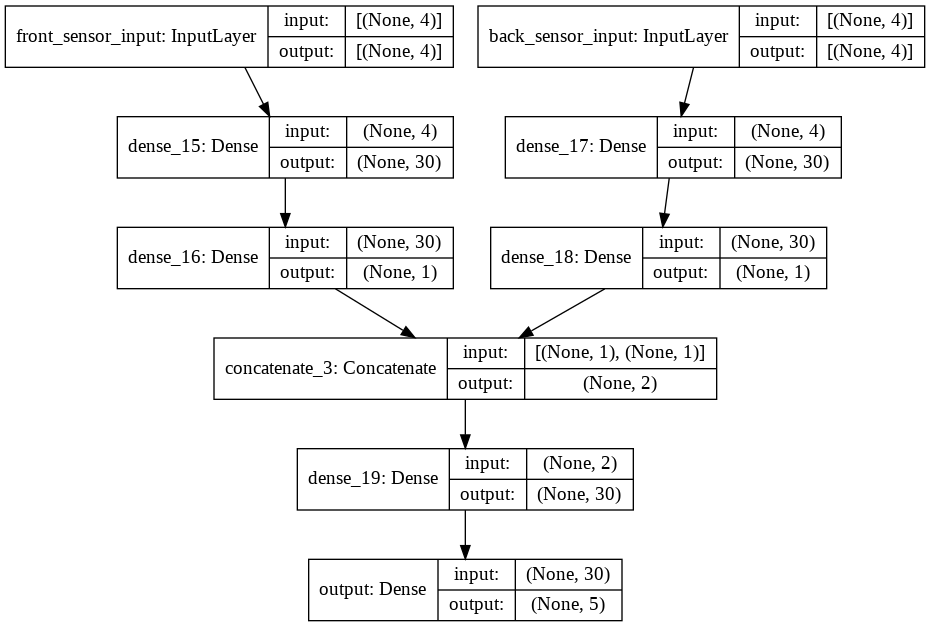

In [ ]:
keras.utils.plot_model(model, "test.png", show_shapes=True)